In [24]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from tc_utils import *
from itertools import dropwhile


In [25]:
home_dir = os.path.dirname(os.path.abspath("makeplots.ipynb"))
lib_dir = home_dir+f'{os.sep}lib'

In [26]:
def make_pathtofit(mat_direct, subset=None):
    path_to_fit_dict = dict()

    fit_str = f"{mat_direct}{os.sep}fits"
    other_str = f"{mat_direct}{os.sep}OTHERFITS"
    nist_str = f"{mat_direct}{os.sep}NIST"
    raw_str = f"{mat_direct}{os.sep}RAW"
    
    mat = os.path.split(mat_direct)[-1] # Get the material name from the directory path

    if os.path.exists(fit_str): # Prioritize RAW fits
        path_to_fit_dict["raw_fit"] = fit_str
    if os.path.exists(other_str): # Then other fits
        path_to_fit_dict["other_fit"] = other_str
    if os.path.exists(nist_str): # Lastly NIST Fits
        path_to_fit_dict["NIST_fit"] = nist_str
    
    return path_to_fit_dict

In [27]:
def compile_csv_2(path_to_fits, mat_name):
    """
    Description : Compiles the fit data of every material and outputs to a single array.
    """
    output_array = []
    for fit in path_to_fits.keys():
        file = path_to_fits[fit]
        if not os.path.exists(f"{file}{os.sep}{mat_name}.csv"):
            for i in ["lo", "hi"]:
                material_file = np.loadtxt(f"{file}{os.sep}{mat_name}_{i}.csv", dtype=str, delimiter=',')
                headers = material_file[0]
                headers = np.append([f"Material Name"], headers)
                comb_fit = material_file[-1]
                comb_fit = np.append([f"{fit}_{i}"], comb_fit)
                mat_dict = dict(zip(headers, comb_fit))
                output_array.append(mat_dict)
        else:
            material_file = np.loadtxt(f"{file}{os.sep}{mat_name}.csv", dtype=str, delimiter=',')
            headers = material_file[0]
            headers = np.append(["Material Name"], headers)
            comb_fit = material_file[-1]
            comb_fit = np.append([f"{fit}"], comb_fit)
            mat_dict = dict(zip(headers, comb_fit))
            output_array.append(mat_dict)

    return output_array

In [28]:
for folder_name in os.listdir(lib_dir):
    folder_path = os.path.join(lib_dir, folder_name)
    if os.path.isdir(folder_path):
        # print(f"Folder: {folder_path}")
        paths = make_pathtofit(folder_path)
        # print(paths)
        csv = compile_csv_2(paths, folder_name)
        print(csv)
        create_tc_csv(csv, f"{folder_path}{os.sep}all_fits.csv")

[{'Material Name': 'raw_fit', 'Fit Type': 'Nppoly', 'Low Temp': '0.264', 'High Temp': '1.061', 'Perc Err': '6.458', 'erf param': '0.00e+00', 'a': '-2.22005e+00', 'b': '2.07719e+00', 'c': '2.92536e+01', 'd': '-1.85104e+01'}, {'Material Name': 'NIST_fit', 'Fit Type': 'polylog', 'Low Temp': '4.000', 'High Temp': '300.000', 'Perc Err': '2.0', 'a': '2.33917e+01', 'b': '-1.48573e+02', 'c': '4.22192e+02', 'd': '-6.53666e+02', 'e': '6.07040e+02', 'f': '-3.46152e+02', 'g': '1.18428e+02', 'h': '-2.22781e+01', 'i': '1.77019e+00'}]
[{'Material Name': 'NIST_fit', 'Fit Type': 'polylog', 'Low Temp': '4.000', 'High Temp': '300.000', 'Perc Err': '2.0', 'a': '6.37360e-01', 'b': '-1.14370e+00', 'c': '7.46240e+00', 'd': '-1.26905e+01', 'e': '1.19165e+01', 'f': '-6.18721e+00', 'g': '1.63939e+00', 'h': '-1.72667e-01', 'i': '0.00e+00'}]
[{'Material Name': 'NIST_fit', 'Fit Type': 'polylog', 'Low Temp': '4.000', 'High Temp': '300.000', 'Perc Err': '1.0', 'a': '-9.09330e-01', 'b': '5.75100e+00', 'c': '-1.11120e

In [29]:
def get_parameters(TCdata, index):
    """
    Function: extracts the fit parameters for the specified material

    Arguments: 
    - TCdata: (array) the array of the imported compilation file
    - mat: (string) the material of interest

    Returns: Dictionary of specified material fit parameters.
    """
    headers = TCdata[0] # pulls the headers from the file
    mat_row = TCdata[index] # searches material name array for mat specified above and return relevant row
    param_headers = headers[5:]
    fit_type = mat_row[1]
    print(fit_type)
    num_hi = sum(1 for c in param_headers if c.isupper()) # searches for the number of low parameters (by lower case letter)
    num_low = sum(1 for c in param_headers if c.islower()) # searches for number of high parameters
    fit_params = mat_row 
    fit_params = np.char.replace(fit_params, "^", "0")
    # fit_range, low_param, hi_param, erf_param = np.array(mat_row[2:4], dtype=float), np.array(fit_params[:num_low], dtype=float), np.array(fit_params[num_low:-1], dtype=float), float(fit_params[-1])

    fit_range = np.array(mat_row[2:4], dtype=float) # pulls the fit range
    # loop through headers and if lower case add to low_param vice versa
    low_param = []
    hi_param = []
    erf_param = None
    for key in headers[5:]:
        if key.islower() and key != "erf param":
            low_param.append(float(fit_params[int(np.argwhere(headers == key)[0][0])]))
        elif key.isupper():
            hi_param.append(float(fit_params[int(np.argwhere(headers == key)[0][0])]))
        elif key == "erf param":
            erf_param = float(fit_params[int(np.argwhere(headers == key)[0][0])])

    # now we have a list of lower and upper parameters but, they might have trailing 0s if they have fewer parameters than other materials
    # so now we remove those trailing 0s
    def remove_trailing_zeros(arr):
        return list(dropwhile(lambda x: x == 0, arr[::-1]))
    low_param = remove_trailing_zeros(low_param)
    hi_param = remove_trailing_zeros(hi_param)
    if fit_type not in ["Nppoly", "polylog", "comppoly"]:
        low_param = low_param[::-1]
        hi_param = hi_param[::-1]
    # print(low_param, hi_param, erf_param)
    param_dictionary = {"fit_type":  fit_type,
                        "fit_range": fit_range,
                        "low_param": low_param,
                        "hi_param":  hi_param,
                        "erf_param": erf_param}
    return param_dictionary

Aluminum_1100
Nppoly
<function Nppoly at 0x0000023198716040>
[0.264 1.061]
polylog
<function polylog at 0x00000231987160D0>
[  4. 300.]


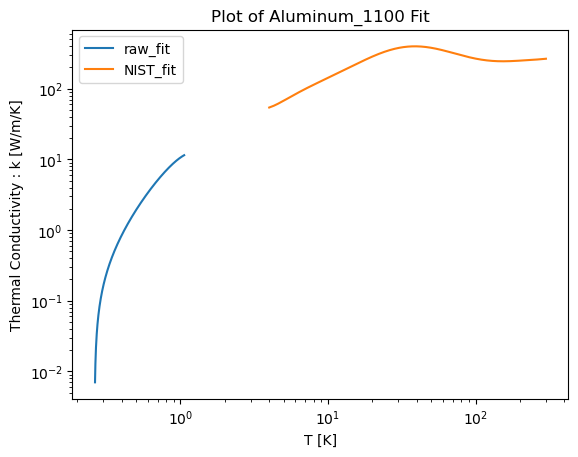

Aluminum_3003F
polylog
<function polylog at 0x00000231987160D0>
[  4. 300.]


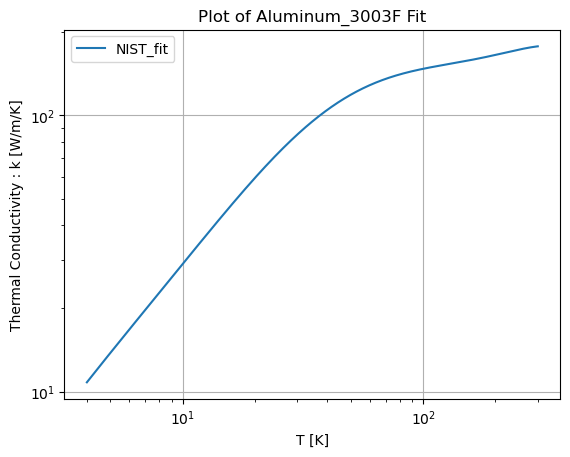

Aluminum_5083O
polylog
<function polylog at 0x00000231987160D0>
[  4. 300.]


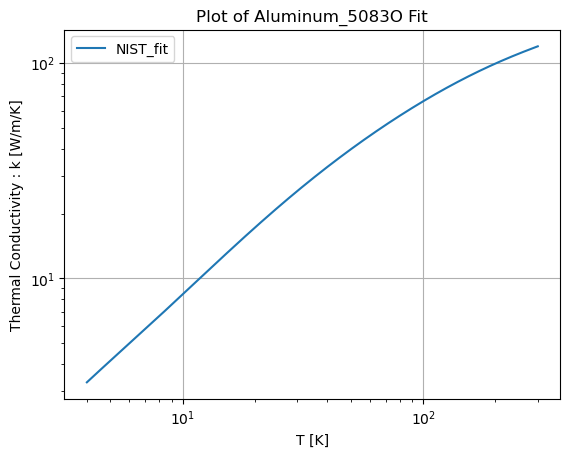

Aluminum_6061T6
polylog
<function polylog at 0x00000231987160D0>
[  4. 300.]


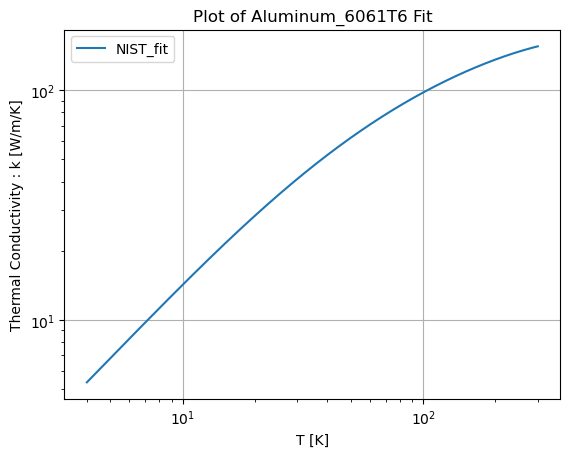

Aluminum_6063T5
polylog
<function polylog at 0x00000231987160D0>
[  4. 296.]


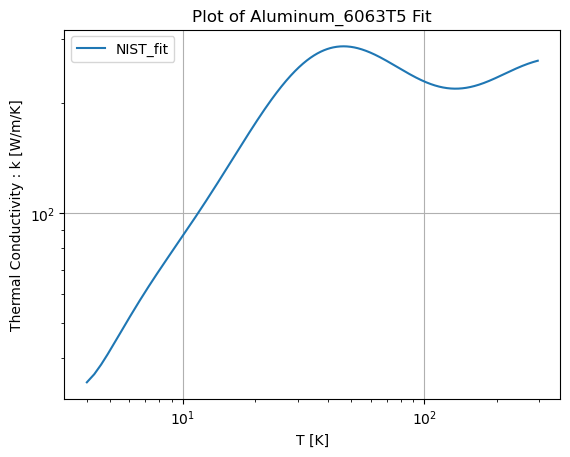

Beryllium_Copper
polylog
<function polylog at 0x00000231987160D0>
[ 2. 80.]


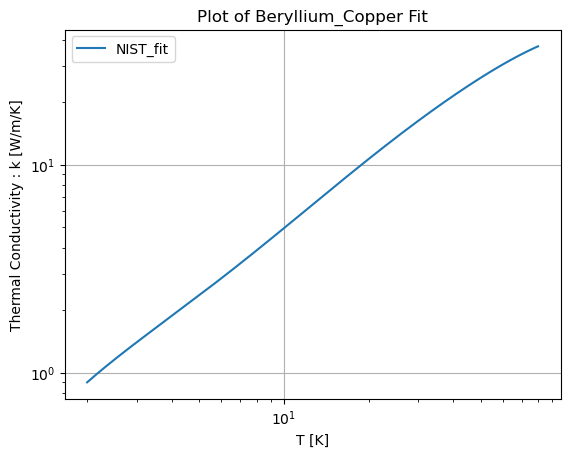

Brass
polylog
<function polylog at 0x00000231987160D0>
[  0. 972.]
polylog
<function polylog at 0x00000231987160D0>
[  5. 116.]


c:\Users\henac\OneDrive - The University of Texas at Austin\01_RESEARCH\05_CMBS4\Cryogenic_Material_Properties\thermal_conductivity\fit_types.py:58: RuntimeWarning: divide by zero encountered in log10
  return 10**np.polyval(param, np.log10(T))
c:\Users\henac\anaconda3\envs\ENAPenv\lib\site-packages\numpy\lib\polynomial.py:779: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv


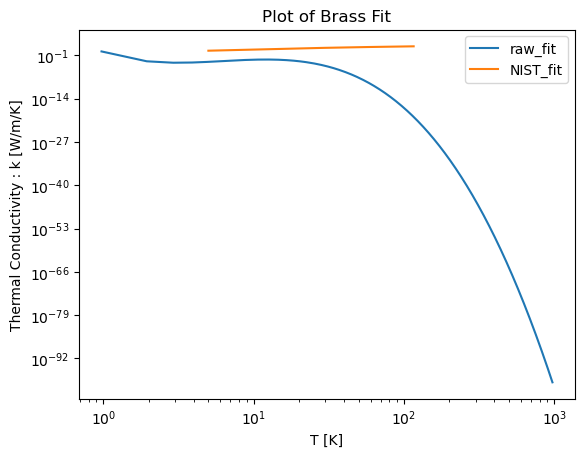

CFRP
Nppoly
<function Nppoly at 0x0000023198716040>
[0.134 4.842]


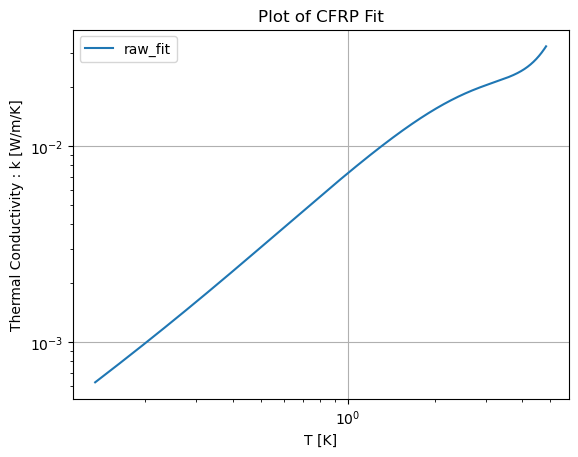

CFRP_Clearwater
Nppoly
<function Nppoly at 0x0000023198716040>
[0.134 4.842]


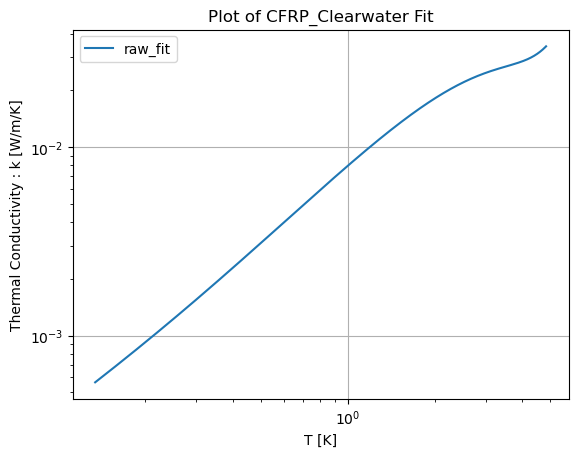

CFRP_DPP
Nppoly
<function Nppoly at 0x0000023198716040>
[0.698 4.02 ]


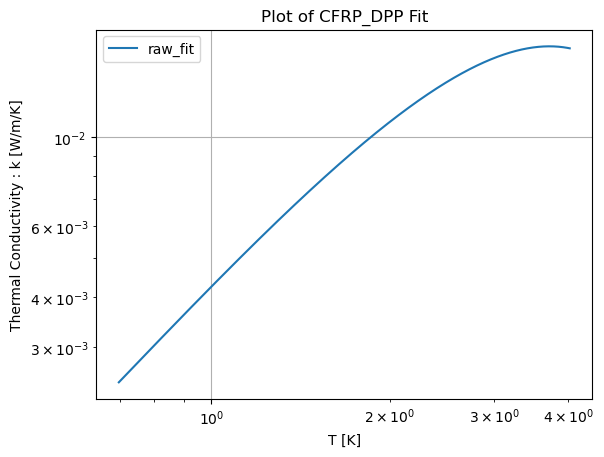

CFRP_Graphlite
Nppoly
<function Nppoly at 0x0000023198716040>
[0.309 4.015]


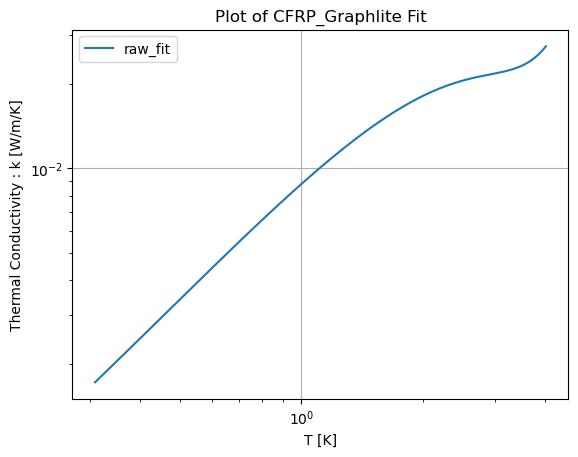

Constantan
Nppoly
<function Nppoly at 0x0000023198716040>
[ 3.03 96.8 ]
polylog
<function polylog at 0x00000231987160D0>
[ 298. 1070.]
TchebyLnT
<function NIST5a_3 at 0x0000023198716670>
[1.e-01 3.e+02]


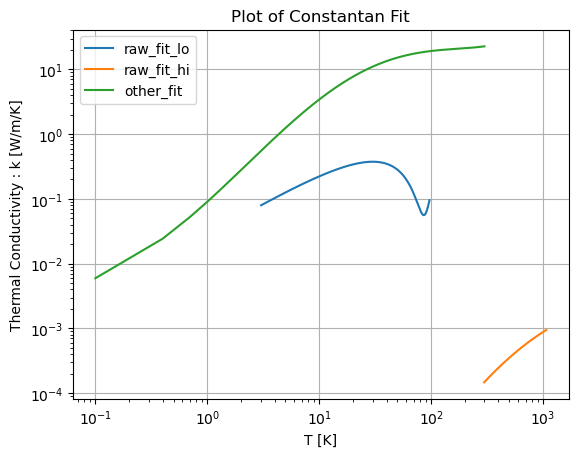

Copper-Nickel
Nppoly
<function Nppoly at 0x0000023198716040>
[0.112 2.755]


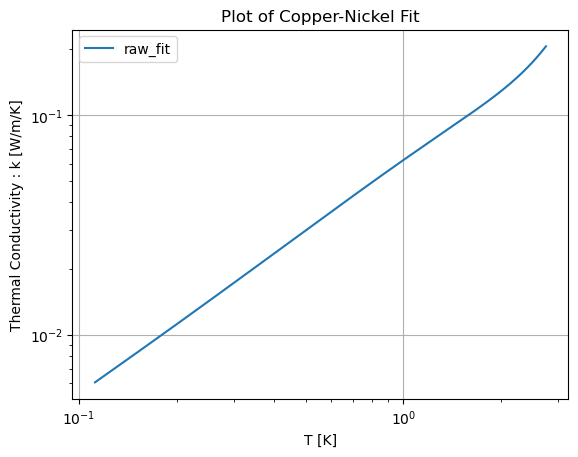

Corian
polylog
<function polylog at 0x00000231987160D0>
[7.70e-02 2.98e+02]


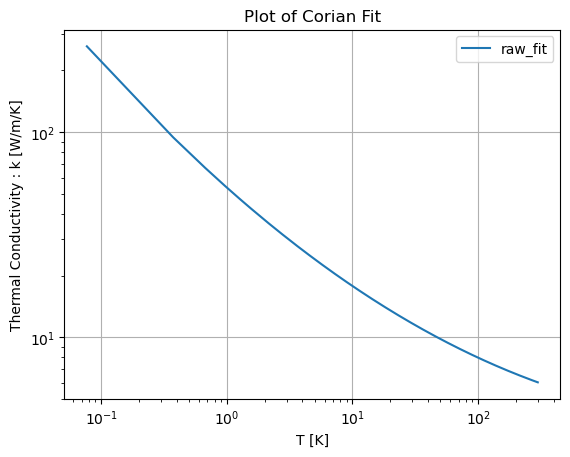

Cu_OFHC
polylog
<function polylog at 0x00000231987160D0>
[  0. 325.]


c:\Users\henac\OneDrive - The University of Texas at Austin\01_RESEARCH\05_CMBS4\Cryogenic_Material_Properties\thermal_conductivity\fit_types.py:58: RuntimeWarning: divide by zero encountered in log10
  return 10**np.polyval(param, np.log10(T))
c:\Users\henac\anaconda3\envs\ENAPenv\lib\site-packages\numpy\lib\polynomial.py:779: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv
c:\Users\henac\OneDrive - The University of Texas at Austin\01_RESEARCH\05_CMBS4\Cryogenic_Material_Properties\thermal_conductivity\fit_types.py:58: RuntimeWarning: overflow encountered in power
  return 10**np.polyval(param, np.log10(T))


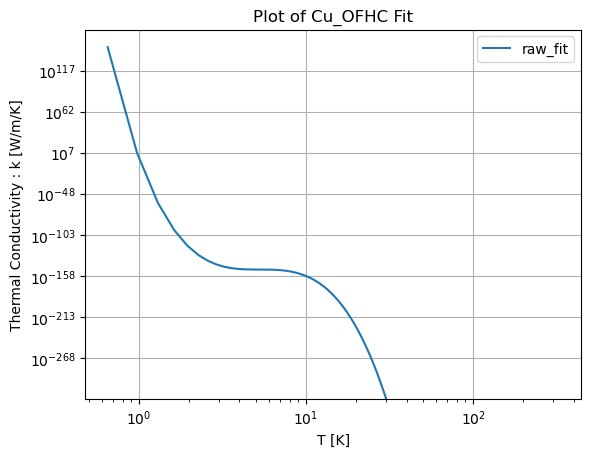

Cu_OFHC_RRR100
NIST-copperfit
<function NIST5a_2 at 0x00000231987165E0>
[  4. 300.]


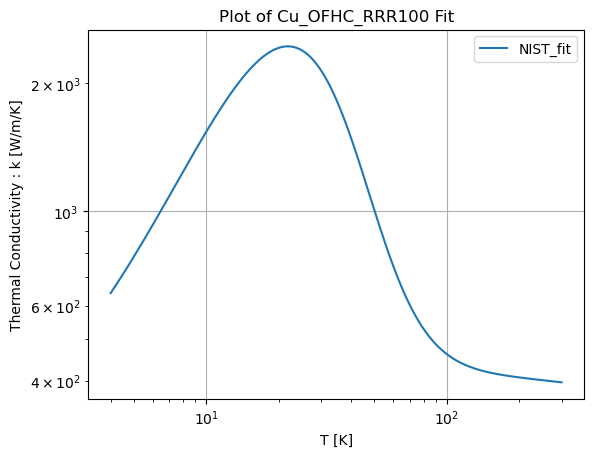

Cu_OFHC_RRR150
NIST-copperfit
<function NIST5a_2 at 0x00000231987165E0>
[  4. 300.]


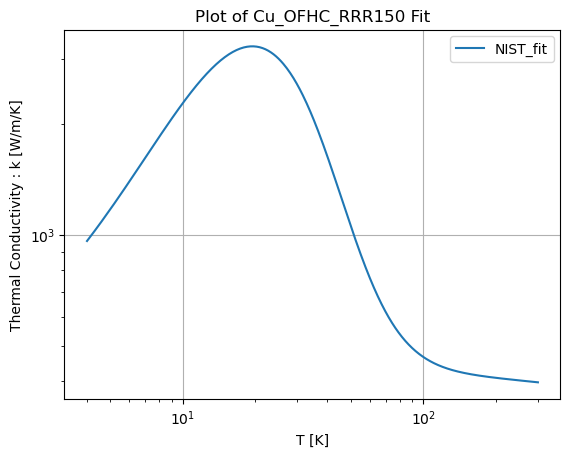

Cu_OFHC_RRR300
NIST-copperfit
<function NIST5a_2 at 0x00000231987165E0>
[  4. 300.]


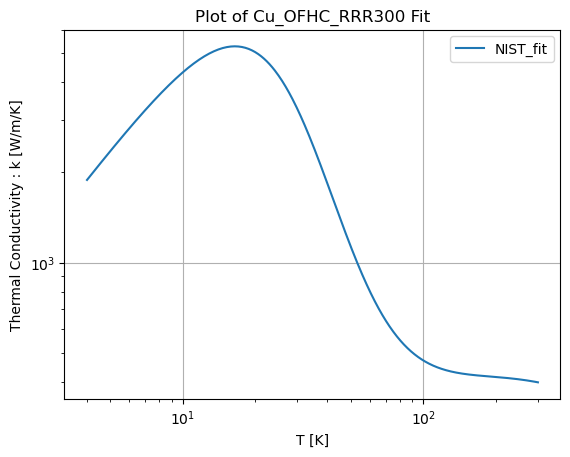

Cu_OFHC_RRR50
NIST-copperfit
<function NIST5a_2 at 0x00000231987165E0>
[  4. 300.]


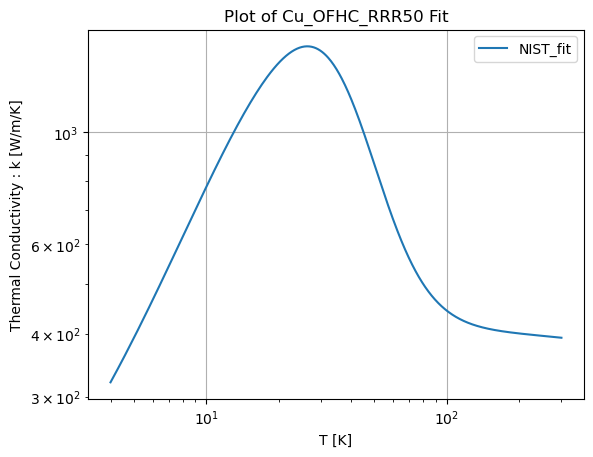

Cu_OFHC_RRR500
NIST-copperfit
<function NIST5a_2 at 0x00000231987165E0>
[  4. 300.]


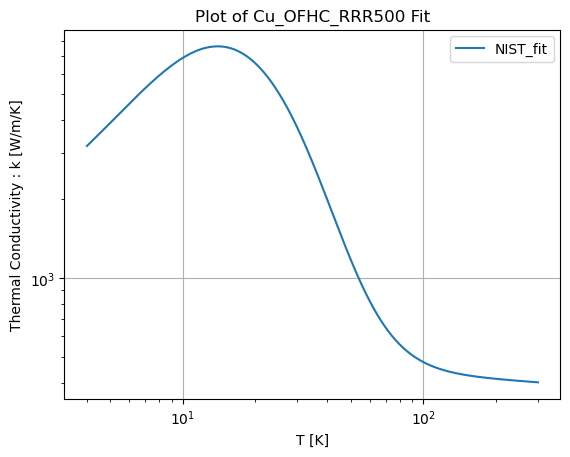

G10_CR_Normal
polylog
<function polylog at 0x00000231987160D0>
[  4. 300.]


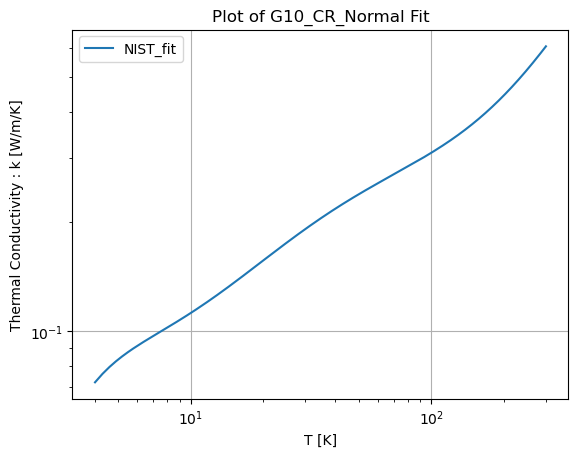

G10_CR_Warp
polylog
<function polylog at 0x00000231987160D0>
[  4. 300.]


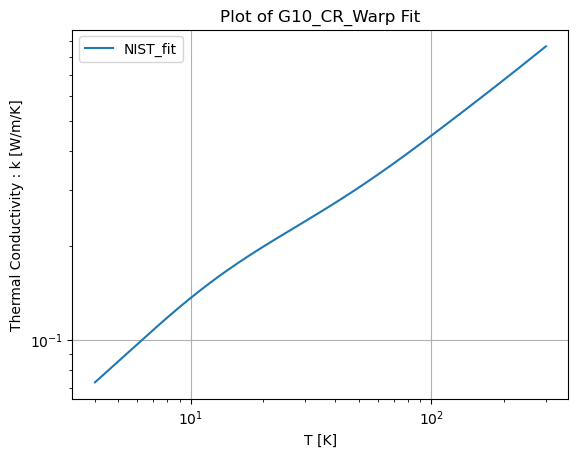

G10_FR4
Nppoly
<function Nppoly at 0x0000023198716040>
[0.304 2.971]


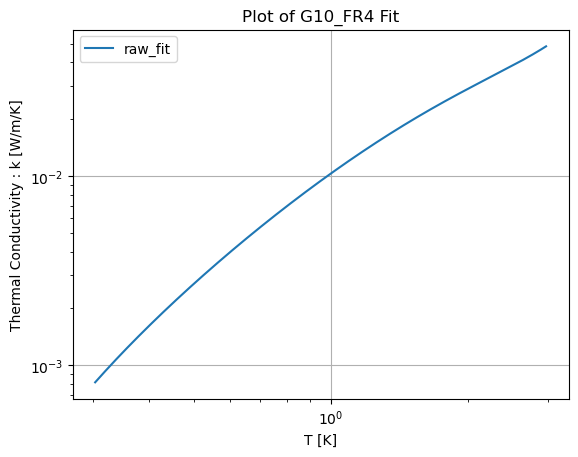

Glass_FabricPolyester_He_warp
polylog
<function polylog at 0x00000231987160D0>
[ 38. 300.]


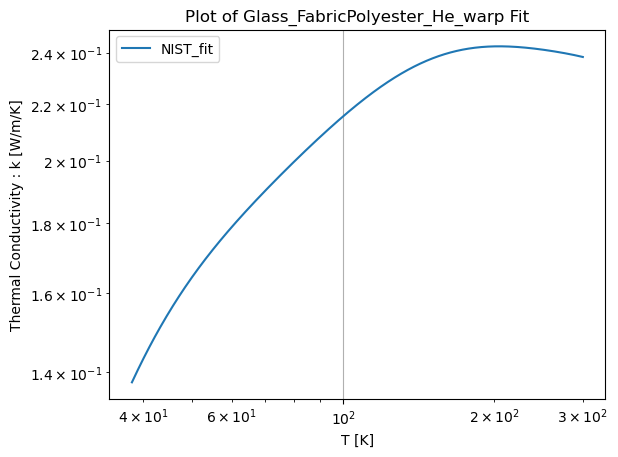

Glass_FabricPolyester_Ni_normal
polylog
<function polylog at 0x00000231987160D0>
[ 84. 300.]


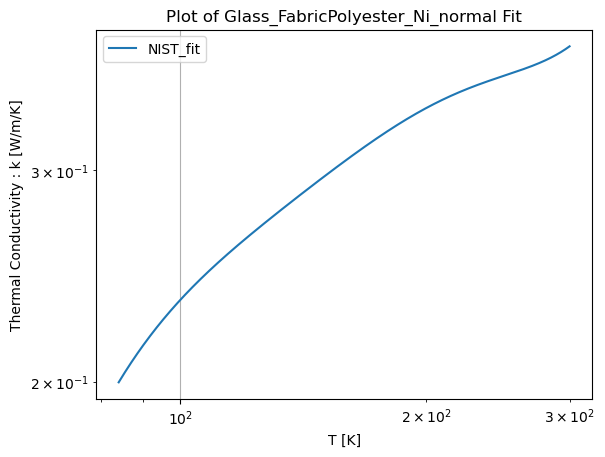

Glass_FabricPolyester_Ni_warp
polylog
<function polylog at 0x00000231987160D0>
[ 80. 300.]


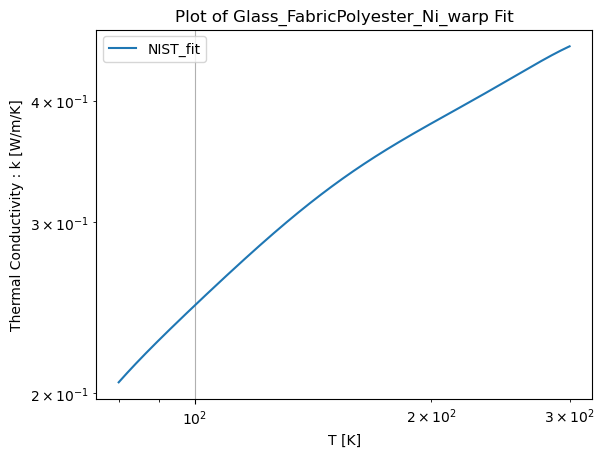

Graphite
lowTextrapolate
<function lowTextrapolate at 0x0000023198716700>
[0.15 1.  ]


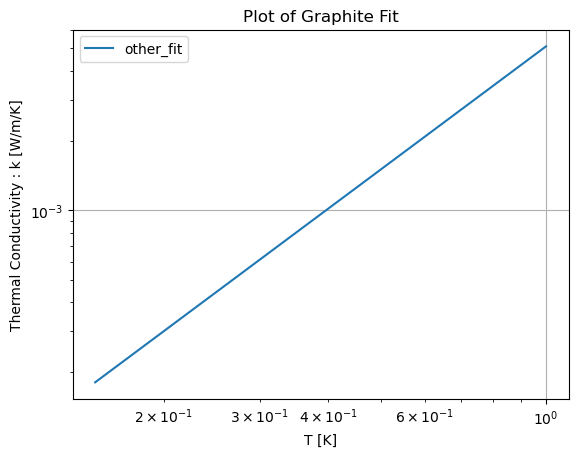

Graphite_a
polylog
<function polylog at 0x00000231987160D0>
[0.06 4.22]


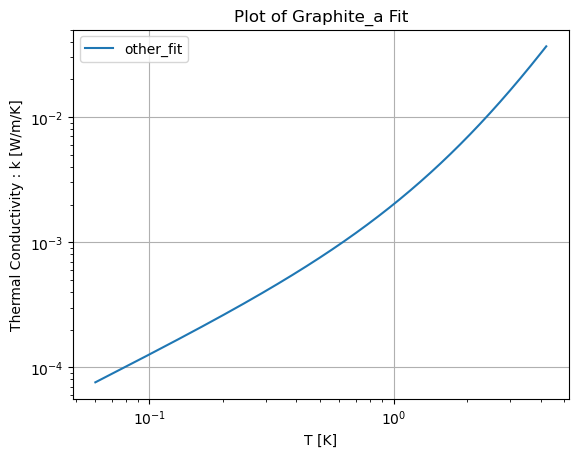

Graphite_brad
lowTextrapolate
<function lowTextrapolate at 0x0000023198716700>
[0.1 5. ]


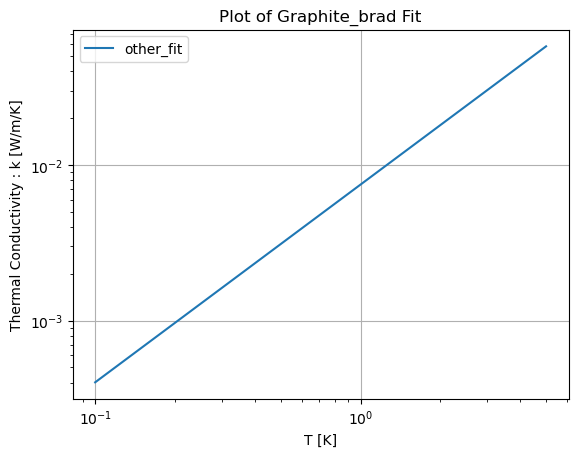

Graphite_p
polylog
<function polylog at 0x00000231987160D0>
[0.06 4.22]


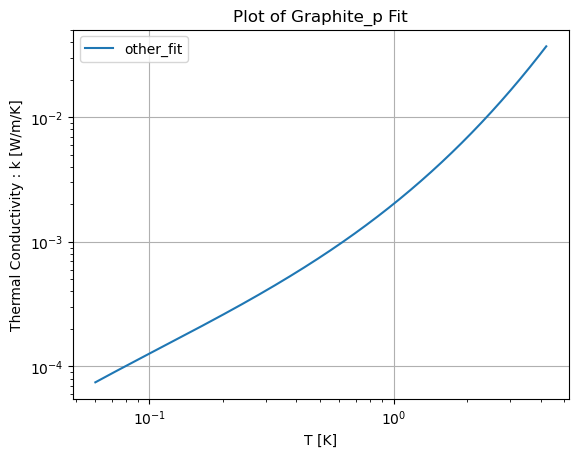

Inconel_718
polylog
<function polylog at 0x00000231987160D0>
[  6. 275.]


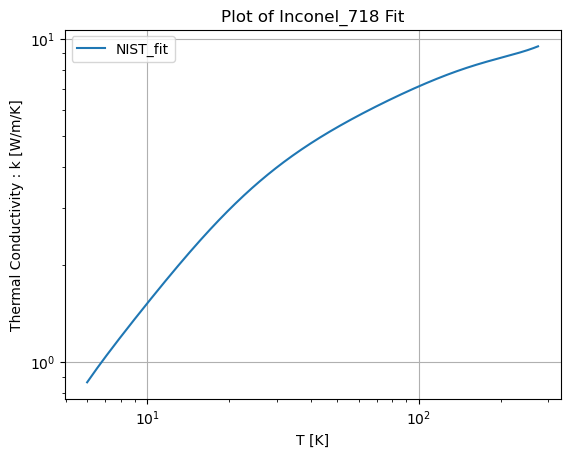

Invar_Fe36Ni
polylog
<function polylog at 0x00000231987160D0>
[  4. 300.]


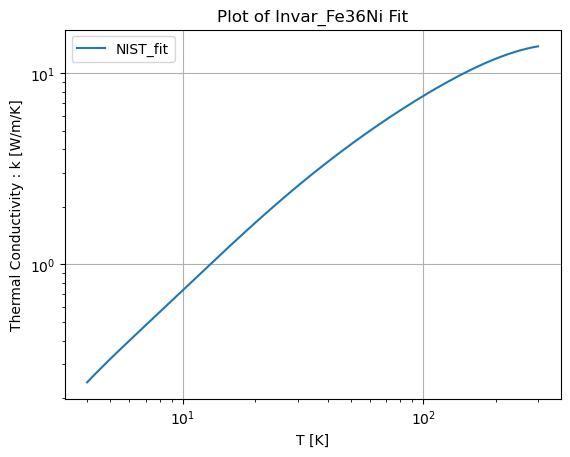

Kapton
comppoly
<function loglog_func at 0x0000023198716160>
[  0. 307.]
polylog
<function polylog at 0x00000231987160D0>
[  4. 300.]


c:\Users\henac\OneDrive - The University of Texas at Austin\01_RESEARCH\05_CMBS4\Cryogenic_Material_Properties\thermal_conductivity\fit_types.py:58: RuntimeWarning: divide by zero encountered in log10
  return 10**np.polyval(param, np.log10(T))
c:\Users\henac\anaconda3\envs\ENAPenv\lib\site-packages\numpy\lib\polynomial.py:779: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv
c:\Users\henac\OneDrive - The University of Texas at Austin\01_RESEARCH\05_CMBS4\Cryogenic_Material_Properties\thermal_conductivity\fit_types.py:86: RuntimeWarning: divide by zero encountered in log10
  erf_low = 0.5*(1-erf(erf_multiplicity*(np.log10((T)/erf_param))))
c:\Users\henac\OneDrive - The University of Texas at Austin\01_RESEARCH\05_CMBS4\Cryogenic_Material_Properties\thermal_conductivity\fit_types.py:87: RuntimeWarning: divide by zero encountered in log10
  erf_hi = 0.5*(1+erf(erf_multiplicity*(np.log10(T/erf_param))))


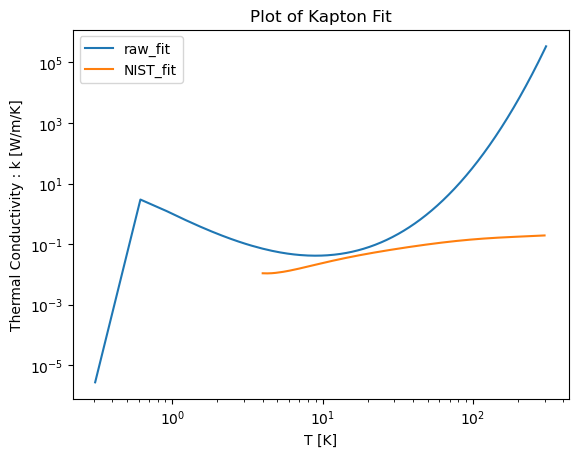

Kaptona
polylog
<function polylog at 0x00000231987160D0>
[  4. 300.]


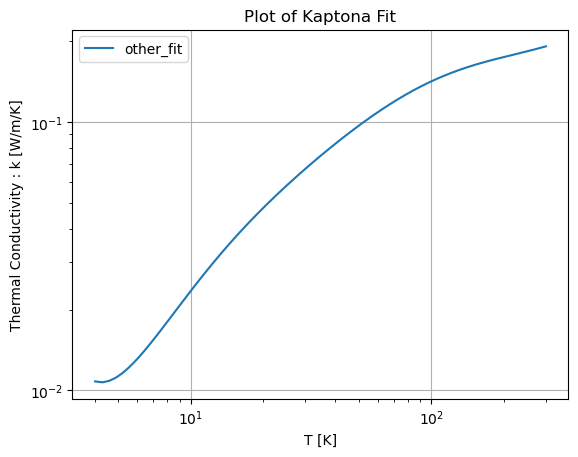

Ketron
Nppoly
<function Nppoly at 0x0000023198716040>
[0.298 2.851]


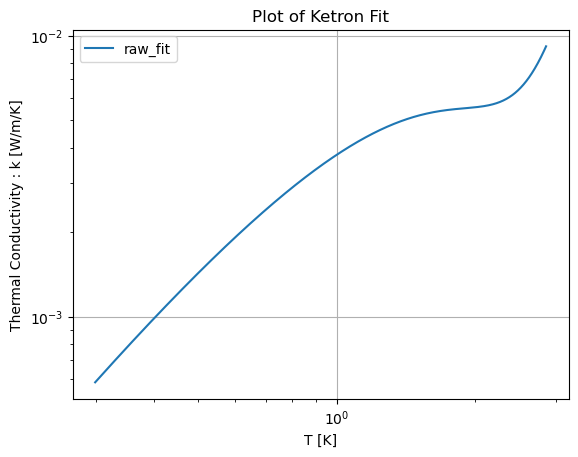

Kevlar49_Composite_Aramid
NIST-experf
<function NIST_experf at 0x0000023198716310>
[  6. 302.]


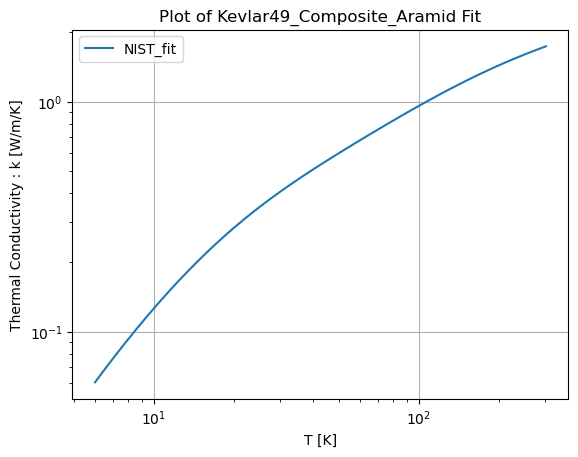

Kevlar49_Fiber_Aramid
NIST-experf
<function NIST_experf at 0x0000023198716310>
[1.00e-01 2.91e+02]


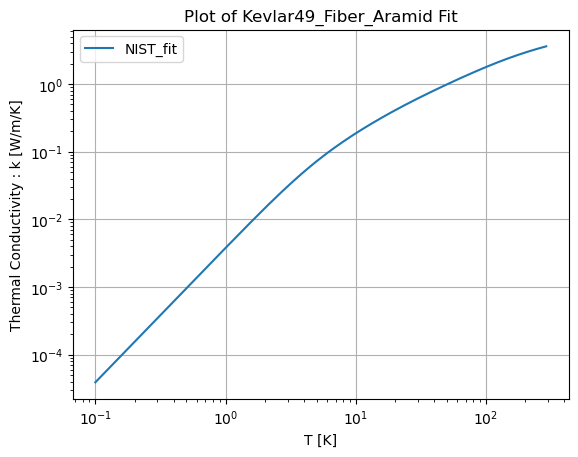

Lead
polylog
<function polylog at 0x00000231987160D0>
[  4. 296.]


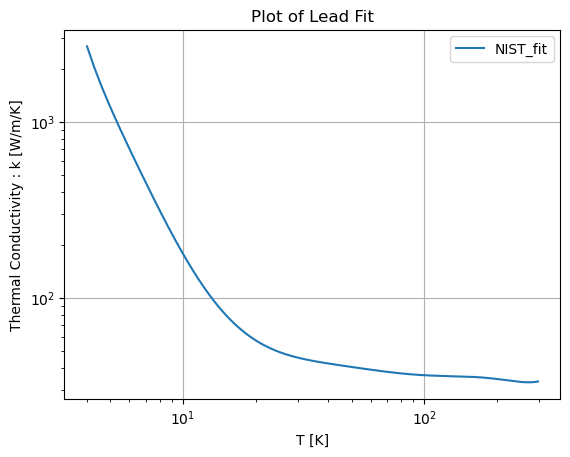

Macor
Nppoly
<function Nppoly at 0x0000023198716040>
[0.337 3.213]


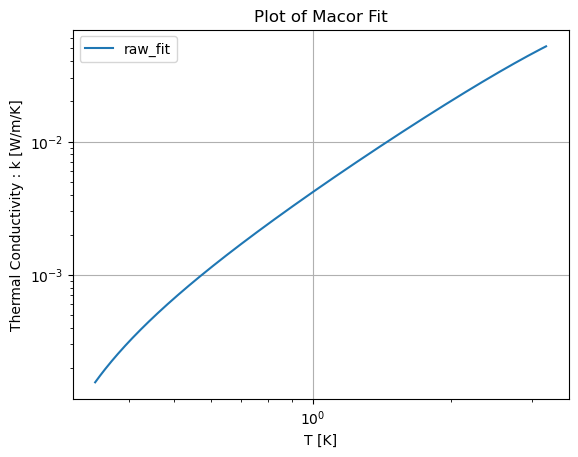

Manganin
comppoly
<function loglog_func at 0x0000023198716160>
[1.00e-02 1.18e+03]
TchebyLnT
<function NIST5a_3 at 0x0000023198716670>
[1.e-01 3.e+02]


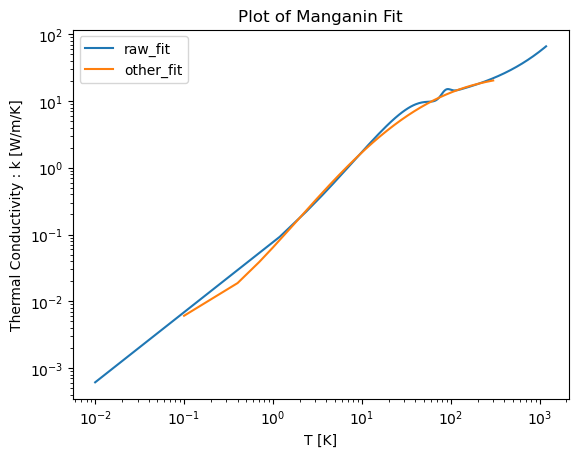

Molybdenum
polylog
<function polylog at 0x00000231987160D0>
[  2. 373.]


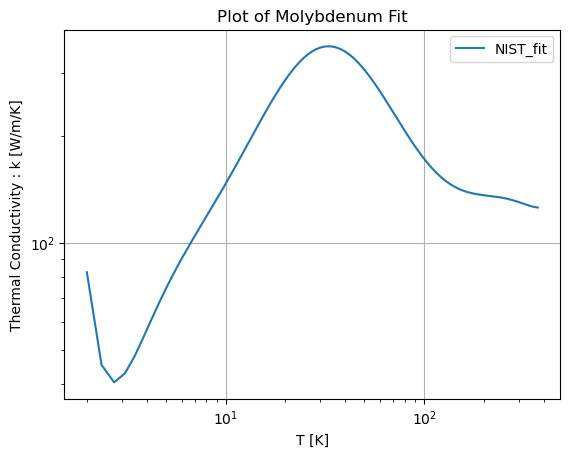

MylarPET
polylog
<function polylog at 0x00000231987160D0>
[ 1. 83.]


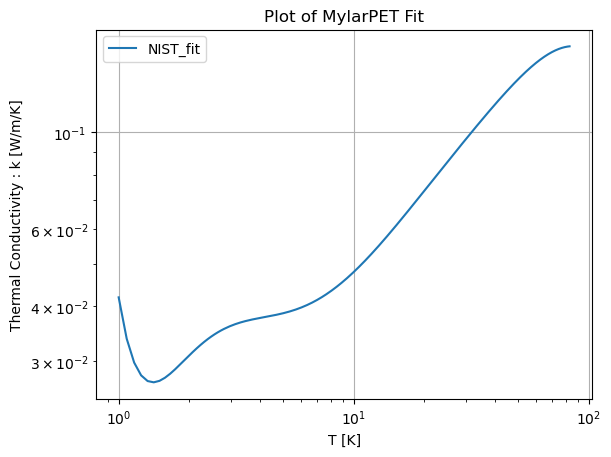

NbTi
polylog
<function polylog at 0x00000231987160D0>
[0.116 9.232]
lowTextrapolate
<function lowTextrapolate at 0x0000023198716700>
[0.01 2.  ]


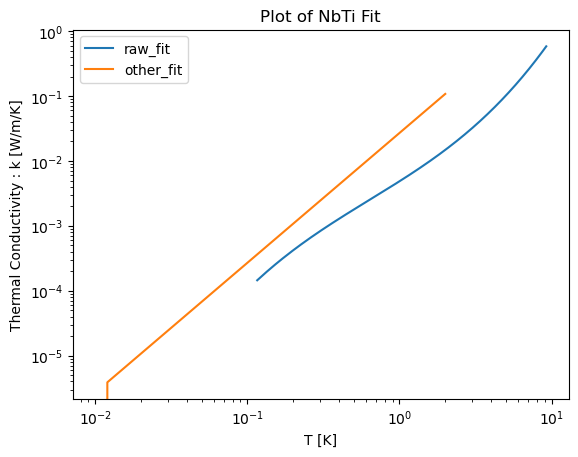

Nichrome
polylog
<function polylog at 0x00000231987160D0>
[  4. 300.]


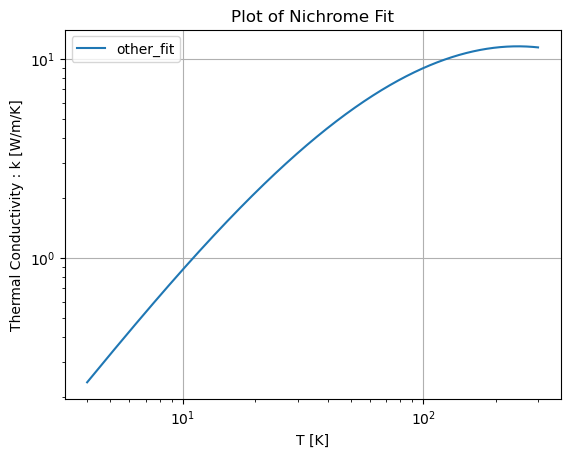

Nickel_Steel_Fe_2.25_Ni
polylog
<function polylog at 0x00000231987160D0>
[  4. 300.]


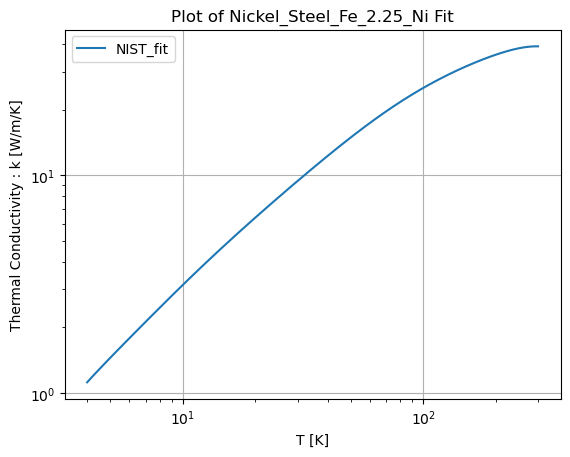

Nickel_Steel_Fe_3.25_Ni
polylog
<function polylog at 0x00000231987160D0>
[  4. 300.]


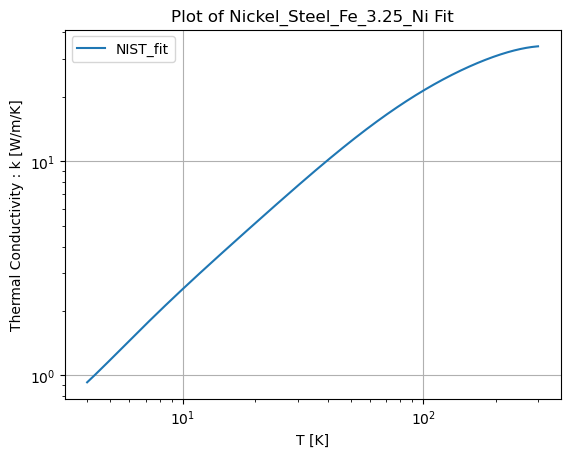

Nickel_Steel_Fe_5.0_Ni
polylog
<function polylog at 0x00000231987160D0>
[  4. 300.]


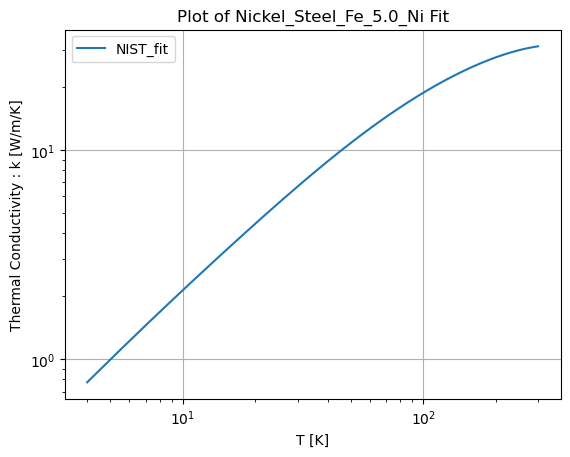

Nickel_Steel_Fe_9.0_Ni
polylog
<function polylog at 0x00000231987160D0>
[  4. 300.]


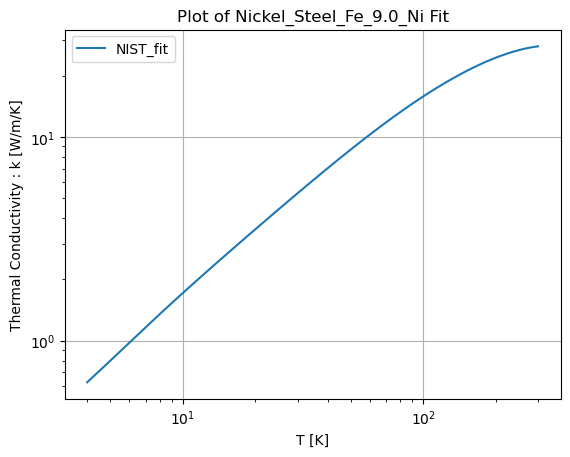

Nylon
polylog
<function polylog at 0x00000231987160D0>
[  4. 300.]


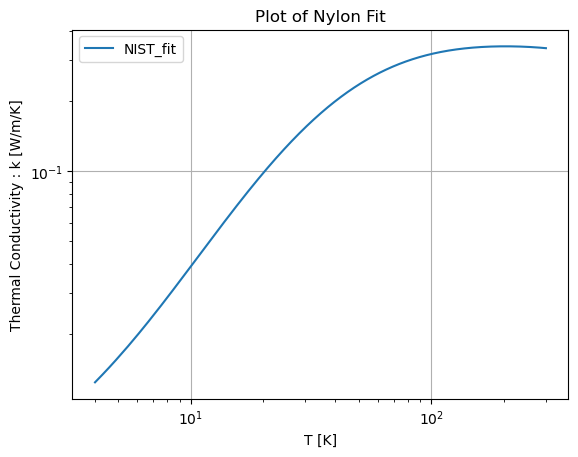

OFHC_RRR
OFHC_RRR_Wc
<function OFHC_RRR_Wc at 0x00000231987168B0>
[2.00e-01 1.25e+03]
TypeError encountered when evaluating OFHC_RRR_Wc with parameters for OFHC_RRR. Skipping this fit.


<Figure size 640x480 with 0 Axes>

Phosphorbronze
comppoly
<function loglog_func at 0x0000023198716160>
[  3.22 448.  ]
polylog
<function polylog at 0x00000231987160D0>
[  1. 300.]


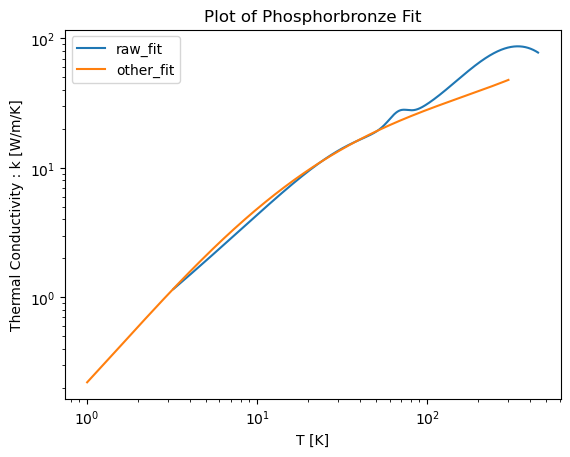

Platinum
polylog
<function polylog at 0x00000231987160D0>
[  3. 298.]


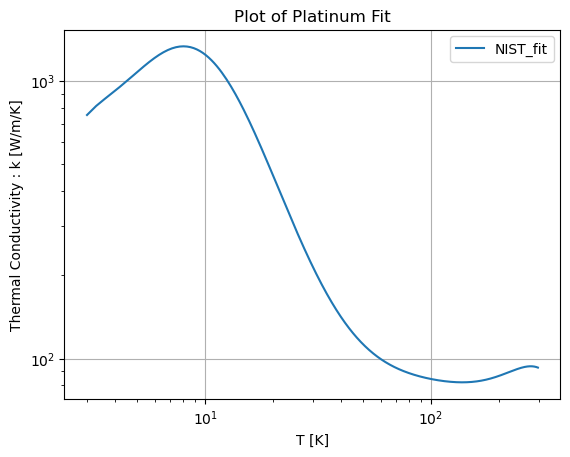

Polystyrene_1.99_lbft3_Freon
polylog
<function polylog at 0x00000231987160D0>
[ 90. 300.]


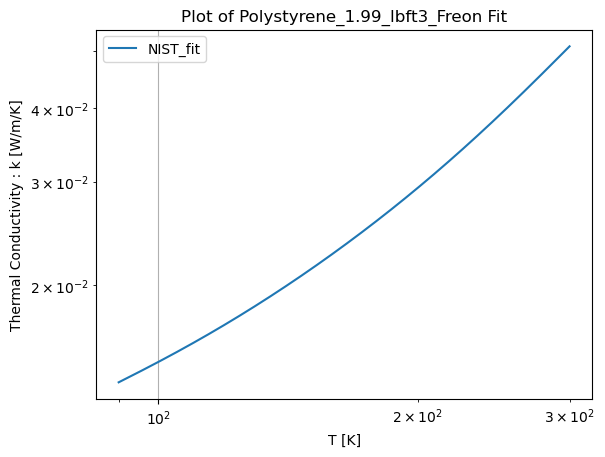

Polystyrene_2.0_lbft3
polylog
<function polylog at 0x00000231987160D0>
[ 33. 300.]


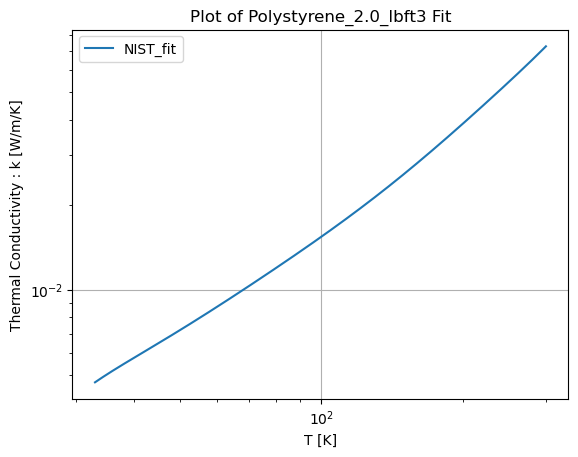

Polystyrene_3.12_lbft3
polylog
<function polylog at 0x00000231987160D0>
[  7. 300.]
polylog
<function polylog at 0x00000231987160D0>
[  7. 300.]


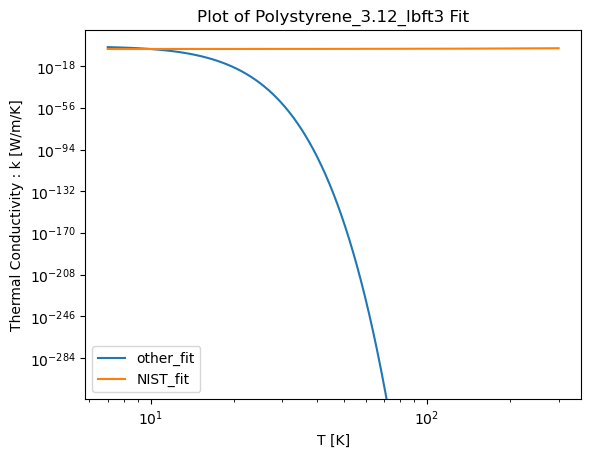

Polystyrene_6.24_lbft3
polylog
<function polylog at 0x00000231987160D0>
[  4. 300.]


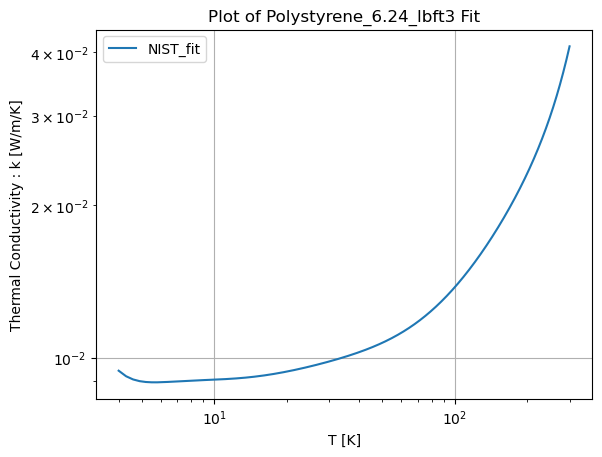

Polyurethane_1.99_lbft3_Freon
polylog
<function polylog at 0x00000231987160D0>
[ 76. 300.]


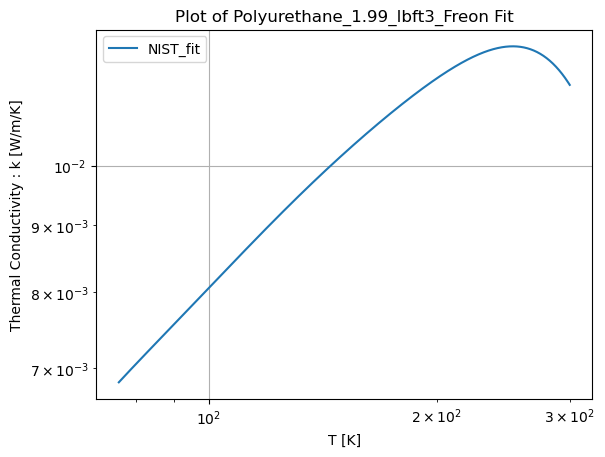

Polyurethane_2.0_lbft3_CO2
polylog
<function polylog at 0x00000231987160D0>
[100. 300.]


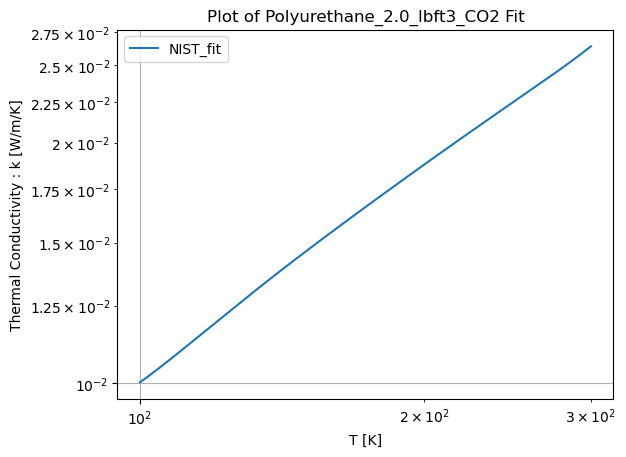

Polyurethane_3.06_lbft3_He
polylog
<function polylog at 0x00000231987160D0>
[ 30. 300.]


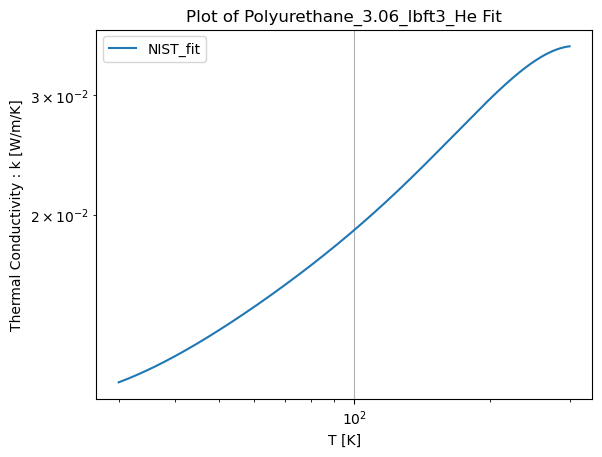

Polyurethane_4.00_lbft3_Freon
polylog
<function polylog at 0x00000231987160D0>
[ 88. 300.]


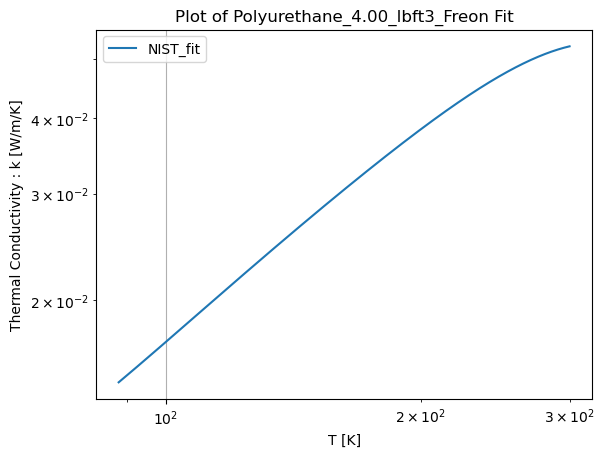

PVC_1.25_lbft3_air
polylog
<function polylog at 0x00000231987160D0>
[100. 300.]


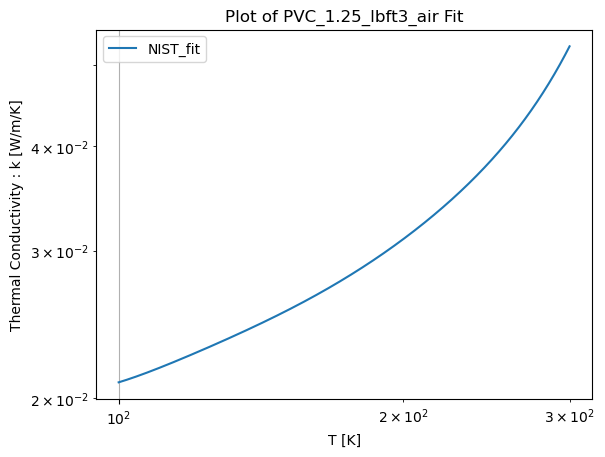

PVC_3.5_lbft3_CO2
polylog
<function polylog at 0x00000231987160D0>
[125. 300.]


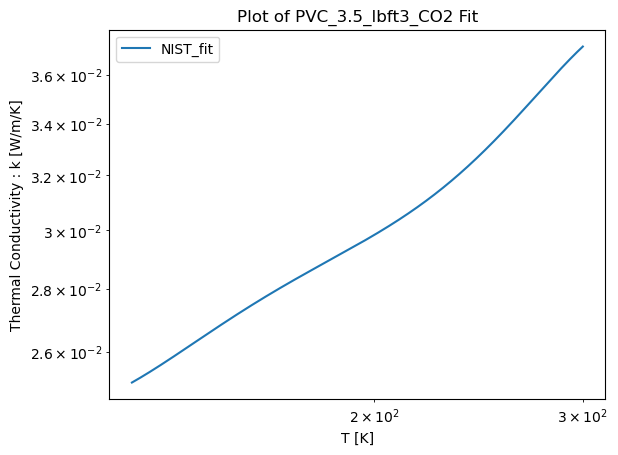

README.md
Silicon
polylog
<function polylog at 0x00000231987160D0>
[  0. 296.]


c:\Users\henac\OneDrive - The University of Texas at Austin\01_RESEARCH\05_CMBS4\Cryogenic_Material_Properties\thermal_conductivity\fit_types.py:58: RuntimeWarning: divide by zero encountered in log10
  return 10**np.polyval(param, np.log10(T))
c:\Users\henac\anaconda3\envs\ENAPenv\lib\site-packages\numpy\lib\polynomial.py:779: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv


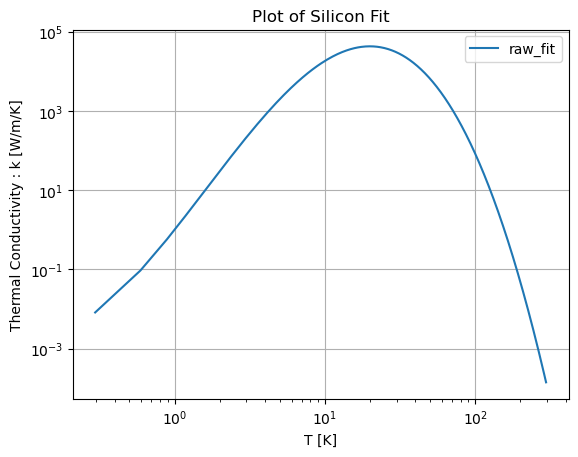

SPAM
Nppoly
<function Nppoly at 0x0000023198716040>
[0.058 1.75 ]


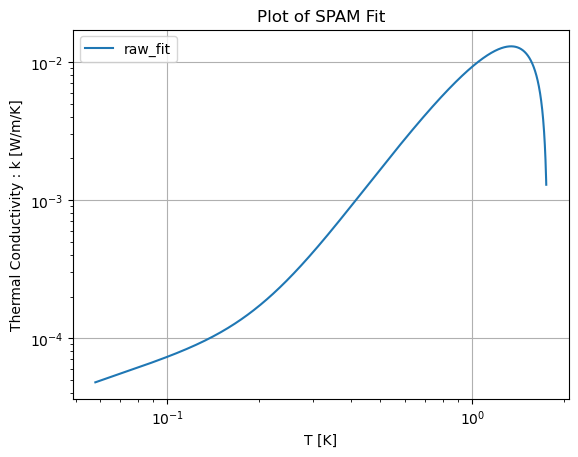

Stainless_Steel
comppoly
<function loglog_func at 0x0000023198716160>
[4.500e-02 1.672e+03]


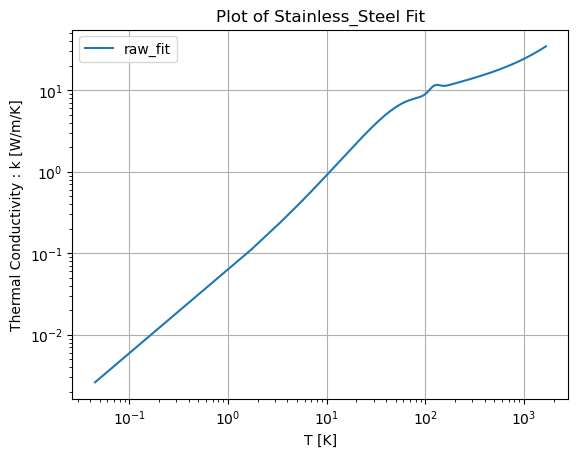

Stainless_Steel_304
comppoly
<function loglog_func at 0x0000023198716160>
[3.850e-01 1.672e+03]
polylog
<function polylog at 0x00000231987160D0>
[  4. 300.]


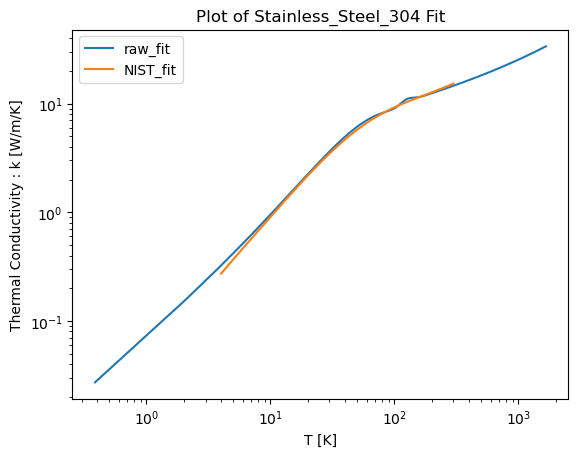

Stainless_Steel_304L
polylog
<function polylog at 0x00000231987160D0>
[  4. 300.]


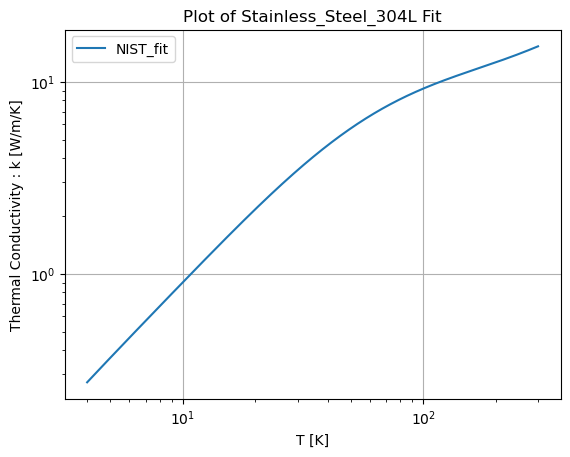

Stainless_Steel_310
Nppoly
<function Nppoly at 0x0000023198716040>
[0.374 1.67 ]
polylog
<function polylog at 0x00000231987160D0>
[ 148.15 1273.15]
polylog
<function polylog at 0x00000231987160D0>
[  4. 300.]


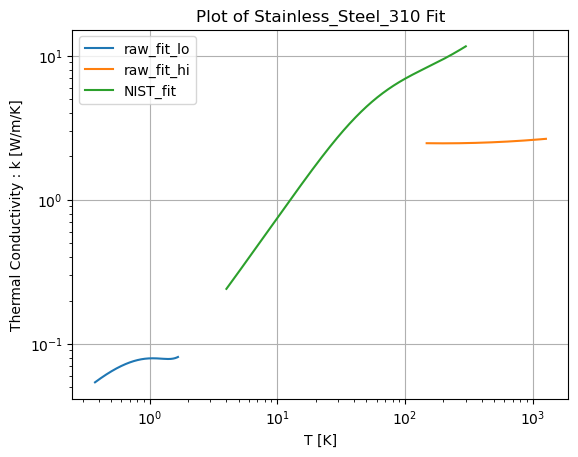

Stainless_Steel_316
Nppoly
<function Nppoly at 0x0000023198716040>
[4.5000e-02 5.7052e+01]
polylog
<function polylog at 0x00000231987160D0>
[ 137.777 1670.15 ]
polylog
<function polylog at 0x00000231987160D0>
[  4. 300.]


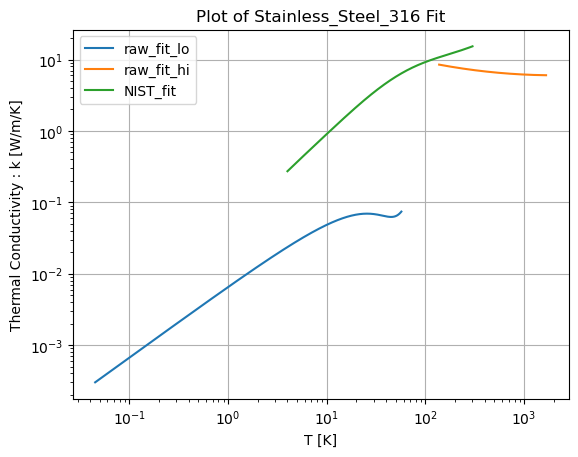

Stainless_Steel_321
comppoly
<function loglog_func at 0x0000023198716160>
[3.930000e-01 1.623194e+03]
loglog


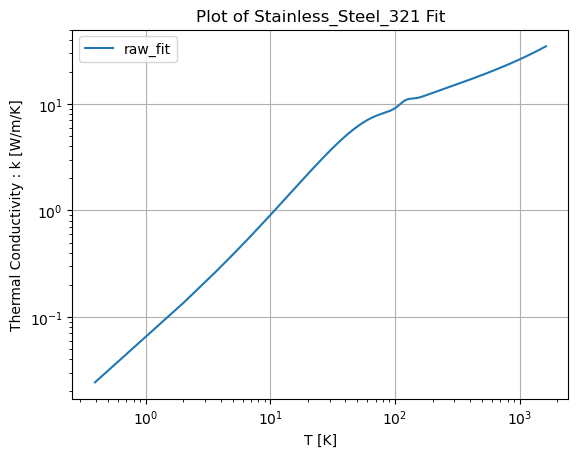

Stycast
polylog
<function polylog at 0x00000231987160D0>
[0.061 1.81 ]


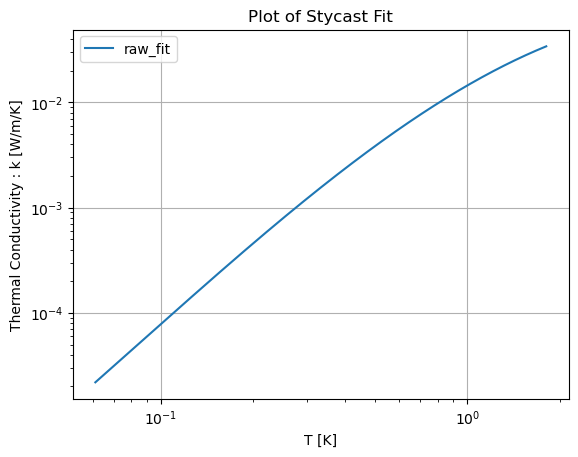

Teflon
polylog
<function polylog at 0x00000231987160D0>
[1.33e-01 2.97e+02]
polylog
<function polylog at 0x00000231987160D0>
[  4. 300.]


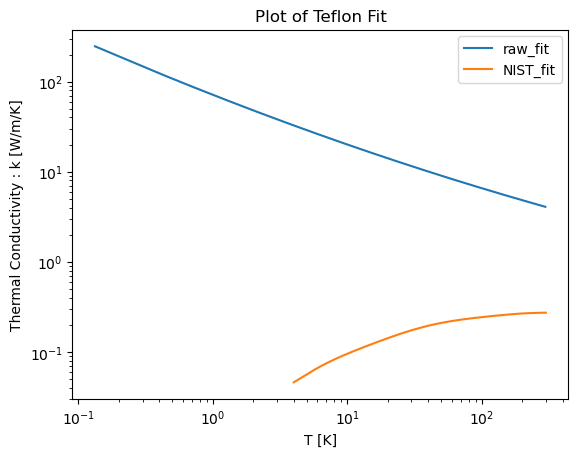

Ti6Al4V
polylog
<function polylog at 0x00000231987160D0>
[6.10000e-02 1.17315e+03]
polylog
<function polylog at 0x00000231987160D0>
[ 23. 300.]


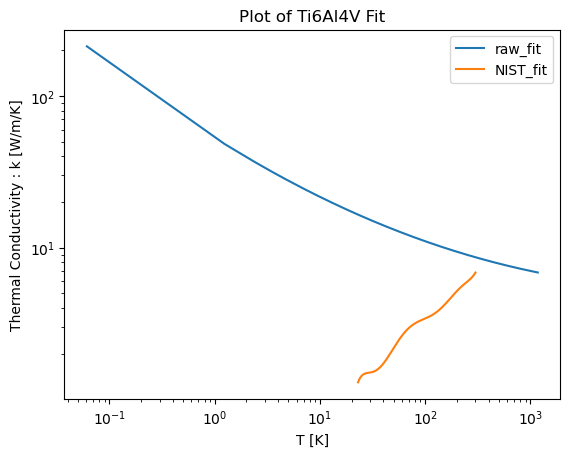

Titanium_15333
polylog
<function polylog at 0x00000231987160D0>
[  1.4 300. ]


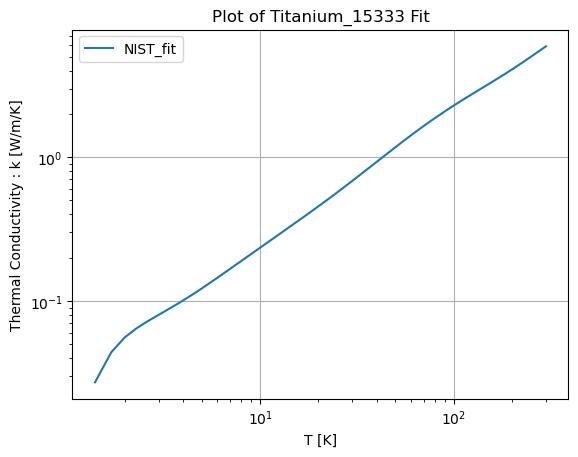

Torlon
Nppoly
<function Nppoly at 0x0000023198716040>
[0.303 2.977]


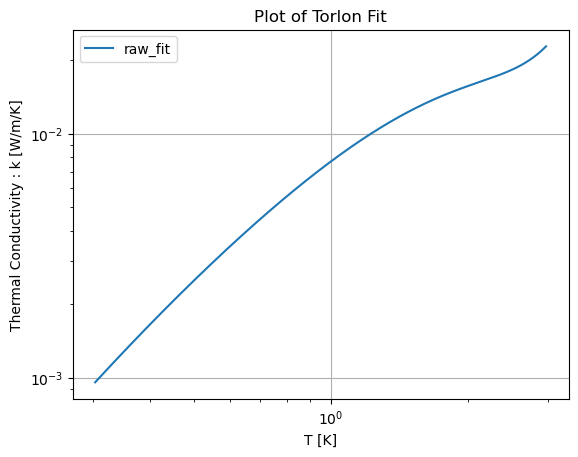

VESPEL
Nppoly
<function Nppoly at 0x0000023198716040>
[0.322 3.032]


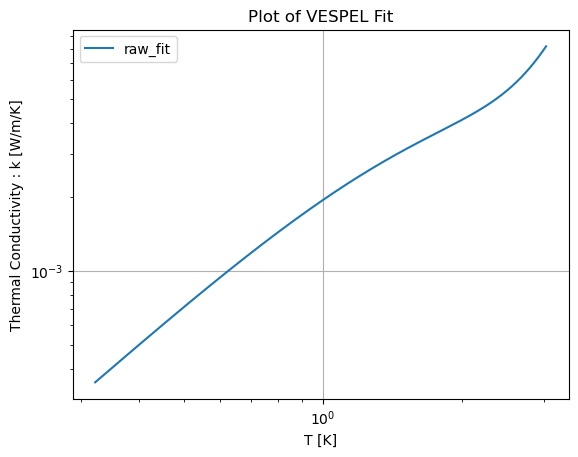

Wood_Balsa_11_lbft3
polylog
<function polylog at 0x00000231987160D0>
[ 88. 300.]


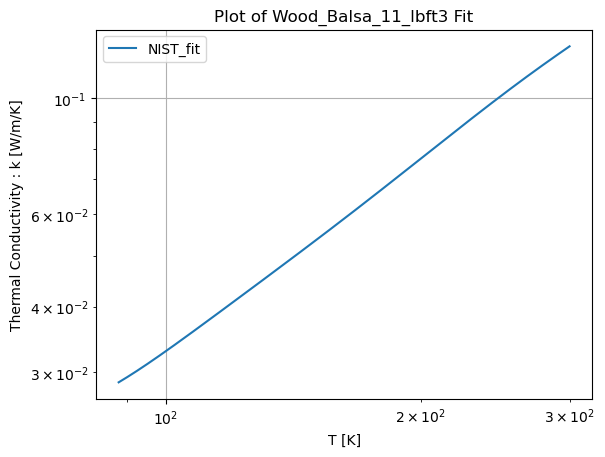

Wood_Balsa_6_lbft3
polylog
<function polylog at 0x00000231987160D0>
[ 88. 300.]


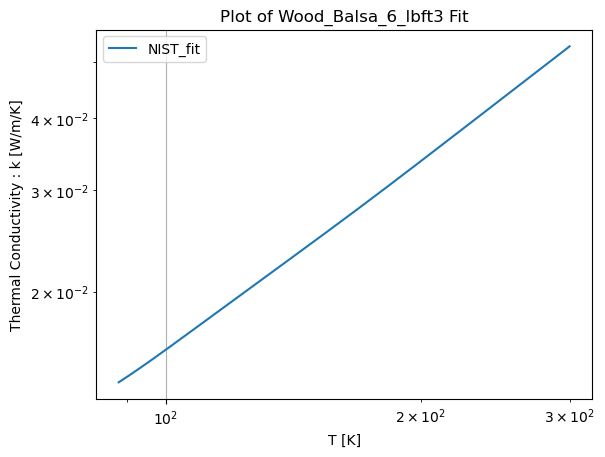

Wood_Beechwood_flatwise
polylog
<function polylog at 0x00000231987160D0>
[ 92. 300.]


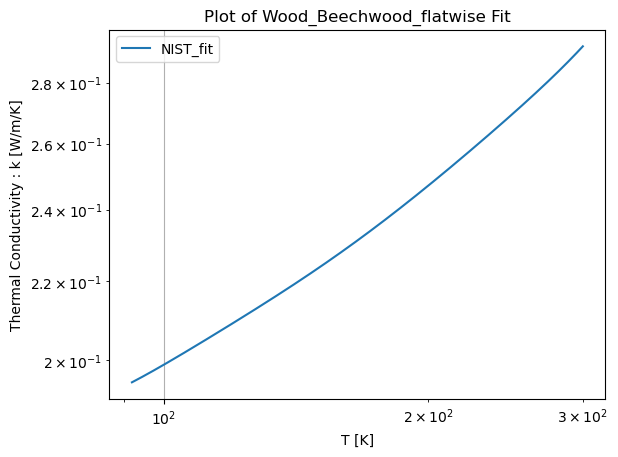

Wood_Beechwood_grain
polylog
<function polylog at 0x00000231987160D0>
[ 92. 300.]


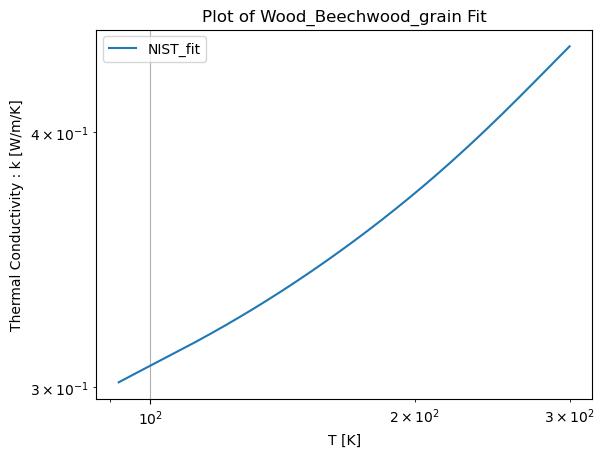

Wood_MapleOak
powerlaw
<function power_law at 0x00000231987161F0>
[3.4e-02 1.0e+03]


<Figure size 640x480 with 0 Axes>

In [30]:
for folder_name in os.listdir(lib_dir):
    folder_path = os.path.join(lib_dir, folder_name)
    print(folder_name)
    if os.path.isdir(folder_path):
        TCdata = np.loadtxt(f"{folder_path}{os.sep}all_fits.csv", dtype=str, delimiter=',') #
        # print(np.shape(TCdata), TCdata)
        for i in range(1, len(TCdata)):
            # print(i)
            mat_parameters = get_parameters(TCdata, i) # get the parameters for the first material in the array (assumes all materials have same fit type)
            # print(parameters)

            try:
                func_type = get_func_type(mat_parameters["fit_type"])
                print(func_type)
                fit_range = mat_parameters["fit_range"]
                print(fit_range)
                # Let's make our plotting range the listed fit range
                T_range = np.linspace(fit_range[0], fit_range[1], 1000)

                # Now let's use the fit to get the thermal conductivity values over the range
                # Luckily, every function type is defined in such a way to readily accept the parameter dictionary as it was defined above
                try:
                    y_vals = func_type(T_range, mat_parameters)
                    # Plotting
                    plt.plot(T_range, y_vals, label=TCdata[i,0]) # Plot the fit line for the material
                    plt.semilogy()
                    plt.semilogx()
                    plt.title(f"Plot of {folder_name} Fit")
                    plt.xlabel("T [K]")
                    plt.ylabel("Thermal Conductivity : k [W/m/K]")
                    plt.grid()
                    plt.legend(loc='best') # Add legend to the plot for the material name or folder name if not specified in the dictionary
                except TypeError:
                    print(f"TypeError encountered when evaluating {func_type.__name__} with parameters for {folder_name}. Skipping this fit.")
            except:
                pass
        # plt.savefig(f"{folder_path}{os.sep}plots{os.sep}{folder_name}_all_fits.pdf", dpi=300) # Save the figure to the folder of the material
        # plt.show()


OFHC_RRR
[['Material Name' 'Fit Type' 'Low Temp' 'High Temp' 'Perc Err' 'a' 'b'
  'c' 'd' 'e' 'f' 'g' 'h' 'i' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6' 'a7' 'a8'
  'a9' 'a10' 'a11' 'a12']
 ['NIST_fit' 'OFHC_RRR_Wc' '0.2' '1250' '??' '0.631' '1.754e-08' '2.763'
  '1102' '-0.165' '70' '1.765' '0.2351' '0.1661' '-0.00012' '420' '470'
  '0.7' '-0.00016' '73' '87' '0.45' '-0.000010' '18' '21' '0.5']]
OFHC_RRR_Wc
<function OFHC_RRR_Wc at 0x00000231987168B0>
[2.00e-01 1.25e+03]
OFHC_RRR_Wc
<function OFHC_RRR_Wc at 0x00000231987168B0>
[2.00e-01 1.25e+03]
OFHC_RRR_Wc
<function OFHC_RRR_Wc at 0x00000231987168B0>
[2.00e-01 1.25e+03]
OFHC_RRR_Wc
<function OFHC_RRR_Wc at 0x00000231987168B0>
[2.00e-01 1.25e+03]


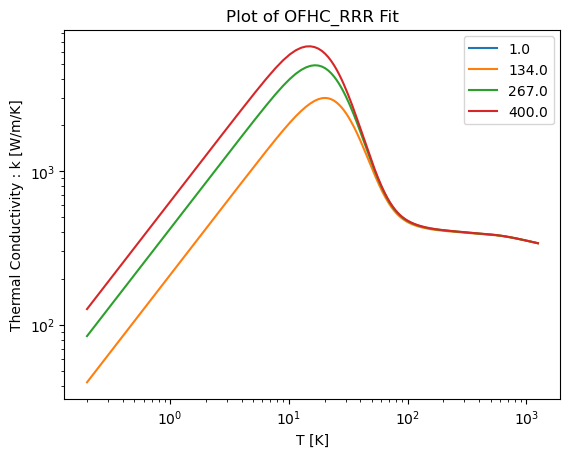

In [34]:
folder_name = "OFHC_RRR"
folder_path = os.path.join(lib_dir, folder_name)
print(folder_name)
if os.path.isdir(folder_path):
    TCdata = np.loadtxt(f"{folder_path}{os.sep}all_fits.csv", dtype=str, delimiter=',') #
    # print(np.shape(TCdata), TCdata)
    print(TCdata)
    RRR_vals = np.linspace(1, 400, 4)
    for i in range(len(RRR_vals)):
        # print(i)
        mat_parameters = get_parameters(TCdata, 1) # get the parameters for the first material in the array (assumes all materials have same fit type)
        # print(parameters)

        
        func_type = get_func_type(mat_parameters["fit_type"])
        print(func_type)
        fit_range = mat_parameters["fit_range"]
        print(fit_range)
        # Let's make our plotting range the listed fit range
        T_range = np.linspace(fit_range[0], fit_range[1], 1000)

        # Now let's use the fit to get the thermal conductivity values over the range
        # Luckily, every function type is defined in such a way to readily accept the parameter dictionary as it was defined above
        
        y_vals = func_type(T_range, [RRR_vals[i]], mat_parameters)
        # Plotting
        plt.plot(T_range, y_vals, label=RRR_vals[i]) # Plot the fit line for the material
        plt.semilogy()
        plt.semilogx()
        plt.title(f"Plot of {folder_name} Fit")
        plt.xlabel("T [K]")
        plt.ylabel("Thermal Conductivity : k [W/m/K]")
        plt.grid()
        plt.legend(loc='best') # Add legend to the plot for the material name or folder name if not specified in the dictionary
        
    plt.savefig(f"{folder_path}{os.sep}plots{os.sep}{folder_name}_all_fits.pdf", dpi=300) # Save the figure to the folder of the material
    plt.show()